### Dataset

In [126]:
from pathlib import Path

Path('../data').mkdir(parents=True, exist_ok=True)
AER_credit_card_data = Path('../data/AER_credit_card_data.csv').resolve()

if not AER_credit_card_data.exists():
    !wget wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv --output-document=$AER_credit_card_data

### Preparation

In [127]:
import pandas as pd

df = pd.read_csv(AER_credit_card_data)
print(df.head(1).T)

mapping_values = {
    'yes': 1,
    'no': 0
}

print(
    f"There are {len(df.isnull().sum()[df.isnull().sum() > 0])} columns with NULL values : {df.isnull().sum()[df.isnull().sum() > 0]}")

                    0
card              yes
reports             0
age          37.66667
income           4.52
share         0.03327
expenditure  124.9833
owner             yes
selfemp            no
dependents          3
months             54
majorcards          1
active             12
There are 0 columns with NULL values : Series([], dtype: int64)


In [128]:
columns_to_map = ['card']

for column in columns_to_map:
    df[column] = df[column].map(mapping_values)
print(df.head(1).T)

                    0
card                1
reports             0
age          37.66667
income           4.52
share         0.03327
expenditure  124.9833
owner             yes
selfemp            no
dependents          3
months             54
majorcards          1
active             12


In [129]:
from sklearn.model_selection import train_test_split

def split_dataset_for_card_prediction(df_full):
    df_full_train, df_test = train_test_split(df_full, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.card.values
    y_val = df_val.card.values
    y_test = df_test.card.values

    del df_train['card']
    del df_val['card']
    del df_test['card']
    return df_full_train, df_train, df_val, df_test, y_train, y_val, y_test

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [130]:
from sklearn.metrics import roc_auc_score
import numpy as np

df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_dataset_for_card_prediction(df)
numerical = df_train.select_dtypes(include=np.number).columns.tolist()

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


In [131]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

use_cols = ["card", "reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
df = df[use_cols]
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_dataset_for_card_prediction(df)
print(df_train.columns)

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

Index(['reports', 'age', 'income', 'share', 'expenditure', 'dependents',
       'months', 'majorcards', 'active', 'owner', 'selfemp'],
      dtype='object')


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [132]:
round(roc_auc_score(y_val, y_pred), 3)

0.995

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [133]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)
    print(f"thresholds {thresholds}")

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

thresholds [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


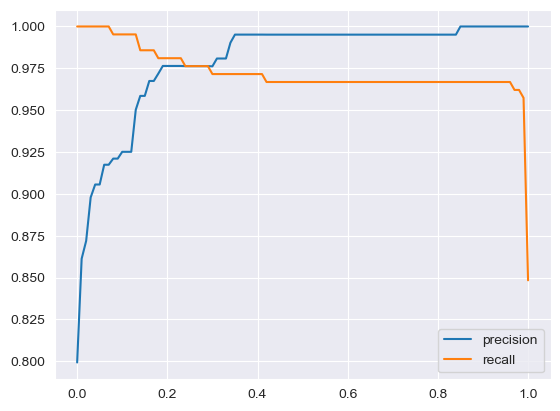

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

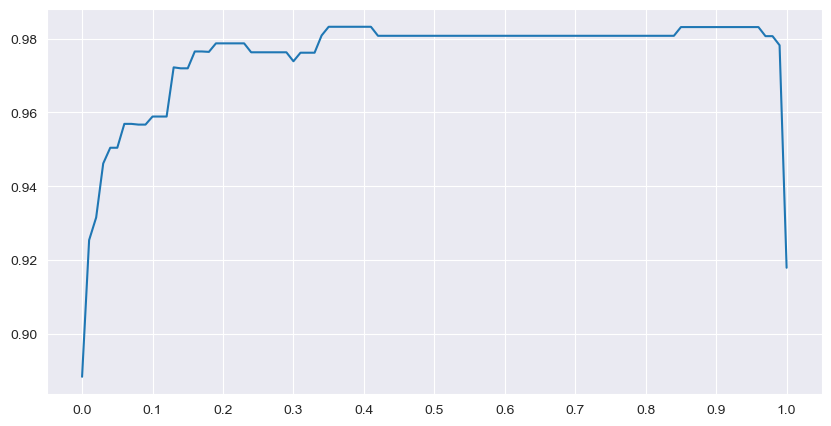

0.35000000000000003, 0.9832134292565947


In [135]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
# plt.vlines(0.3, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()
result = dict(zip(df_scores.threshold, df_scores.f1))
print(f"{max(result, key=result.get)}, {result[max(result, key=result.get)]}")

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [136]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

def train(df_train, y_train, C=1.0):
    dicts = df_train[cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

def predict(df, dv, model):
    dicts = df[cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
    print(scores)

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.992 +- 0.006
[0.985326688815061, 0.9895833333333333, 0.9860342555994731, 0.9977944992215879, 0.9998615725359911]
C=0.01 0.995 +- 0.004
[0.9929401993355481, 0.9926470588235294, 0.991699604743083, 1.0, 1.0]
C=0.1 0.997 +- 0.003
[0.9939091915836102, 0.9947303921568628, 0.99433465085639, 0.9998702646600934, 0.9998615725359911]
C=0.5 0.996 +- 0.003
[0.9940476190476191, 0.9944852941176471, 0.9935441370223979, 0.9997405293201868, 1.0]
C=1 0.996 +- 0.003
[0.9943244739756367, 0.9944852941176471, 0.9938076416337287, 0.9997405293201868, 1.0]
C=5 0.996 +- 0.003
[0.9941860465116279, 0.9941176470588236, 0.9942028985507245, 0.9997405293201868, 1.0]
C=10 0.997 +- 0.003
[0.9946013289036545, 0.9941176470588236, 0.994729907773386, 0.9997405293201868, 1.0]


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [137]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.995 +- 0.004
C= 0.1, 0.997 +- 0.003
C=   1, 0.996 +- 0.003
C=  10, 0.997 +- 0.003
